In [3]:
### Attempt at scraping data from PGAtour.com

In [4]:
#Imports
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [5]:
##Mega function
def make_dataframe(url, categories):
        
    ##Make soup function
    response = requests.get(url)
    text = response.text
    soup = BeautifulSoup(text, 'lxml')
    
    def get_headers(soup):
        '''This function get's the column names to use for the data frame.'''
        headers = []
    
        #Get rounds header
        rounds = soup.find_all(class_="rounds hidden-small hidden-medium")[0].get_text()
        headers.append(rounds)
    
        #Get other headers
        stat_headers = soup.find_all(class_="col-stat hidden-small hidden-medium")
        for header in stat_headers:
            headers.append(header.get_text())
    
        return headers
    headers = get_headers(soup)
    
    #Get Players
    def get_players(soup):
        '''This function takes the beautiful soup created and uses it to gather player names from the specified stats page.'''
    
        player_list = []
    
        #Get player as html tags
        players = soup.select('td a')[1:] #Use 1 beacuse first line of all tables is not useful.
    
        #Loop through list
        for player in players:
            player_list.append(player.get_text())
    
        return player_list
    players = get_players(soup)
    
    ##Get Stats
    def get_stats(soup, categories):
        '''This function takes the soup created before and the number of categories needed to generate this'''
    
        #Finds all tags with class specified and puts into a list
        stats = soup.find_all(class_="hidden-small hidden-medium")
    
        #Initialize stats list
        stat_list = []
    
        #Loop through 
        for i in range(0, len(stats)-categories+1, categories):
            temp_list = []
            for j in range(categories):
                temp_list.append(stats[i + j].get_text())
            stat_list.append(temp_list)
            
        return stat_list
    stats = get_stats(soup, categories)
    
    def stats_dict(players, stats):
        '''This function takes two lists, players and stats, 
        and creates a dictionary with the player being the key 
        and the stats as the vales (as a list)'''
    
        #initialize player dictionary
        player_dict = {}
    
        #Loop through player list
        for i, player in enumerate(players):
            player_dict[player] = stats[i]
    
        return player_dict
    stats_dict = stats_dict(players, stats)
    
    def make_frame(stats_dict, headers):
        return pd.DataFrame(stats_dict, index = headers)
    
    frame = make_frame(stats_dict, headers).transpose()
    frame = frame.reset_index()
    frame = frame.rename(index = str, columns = {'index': 'NAME'})
    return frame
  

In [6]:
#Create your data frames using the url for the stat page and the number of categories after the players name as the two arguments.
fcp_2017 = make_dataframe("https://www.pgatour.com/stats/stat.02671.2017.html", 6)
top10_2017 = make_dataframe("https://www.pgatour.com/stats/stat.138.2017.html", 5)
scoring_2017 = make_dataframe("https://www.pgatour.com/stats/stat.120.2017.html", 5)
drivedistance_2017 = make_dataframe("https://www.pgatour.com/stats/stat.101.2017.html", 4)
driveacc_2017 = make_dataframe("https://www.pgatour.com/stats/stat.102.2017.html", 4)
driveacc_2017 = driveacc_2017.rename(columns = {'%': "FWY %"})
gir_2017 = make_dataframe("https://www.pgatour.com/stats/stat.103.2017.html", 5)
gir_2017 = gir_2017.rename(columns = {'%': "GIR %"})




In [7]:
## Success!! Goal achieved.
##Now, nextsStep: Get multiple data frames, mere on player name, create mega data frame for analysis

In [8]:
dfs = [fcp_2017, top10_2017, scoring_2017, drivedistance_2017, driveacc_2017, gir_2017]

In [9]:
from functools import reduce
dffinal = []
dffinal = reduce(lambda left, right: pd.merge(left, right, on='NAME'), dfs)
df_2017 = dffinal[['NAME', 'POINTS', '# OF WINS', "# OF TOP 10'S", 'AVG', 'AVG.', 'FWY %', 'GIR %']]
df_2017 = df_2017.rename(columns = {'AVG.':'DRIVING AVG.'})
df_2017['POINTS'] = df_2017['POINTS'].apply(lambda x: x.replace(',', ''))
df_2017[['POINTS', '# OF WINS', "# OF TOP 10'S", 'AVG', 'DRIVING AVG.',
       'FWY %', 'GIR %']] = df_2017[['POINTS', '# OF WINS', "# OF TOP 10'S", 'AVG', 'DRIVING AVG.',
       'FWY %', 'GIR %']].apply(pd.to_numeric)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

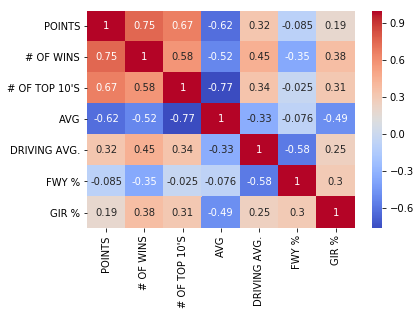

In [11]:
sns.heatmap(df_2017.corr(),cmap='coolwarm',annot=True)

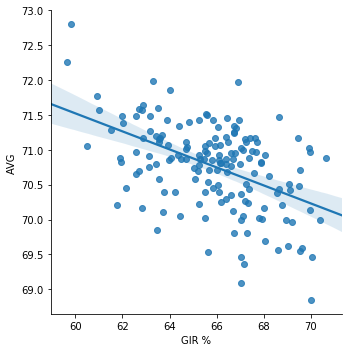

In [12]:
sns.lmplot('GIR %', 'AVG', data = df_2017)

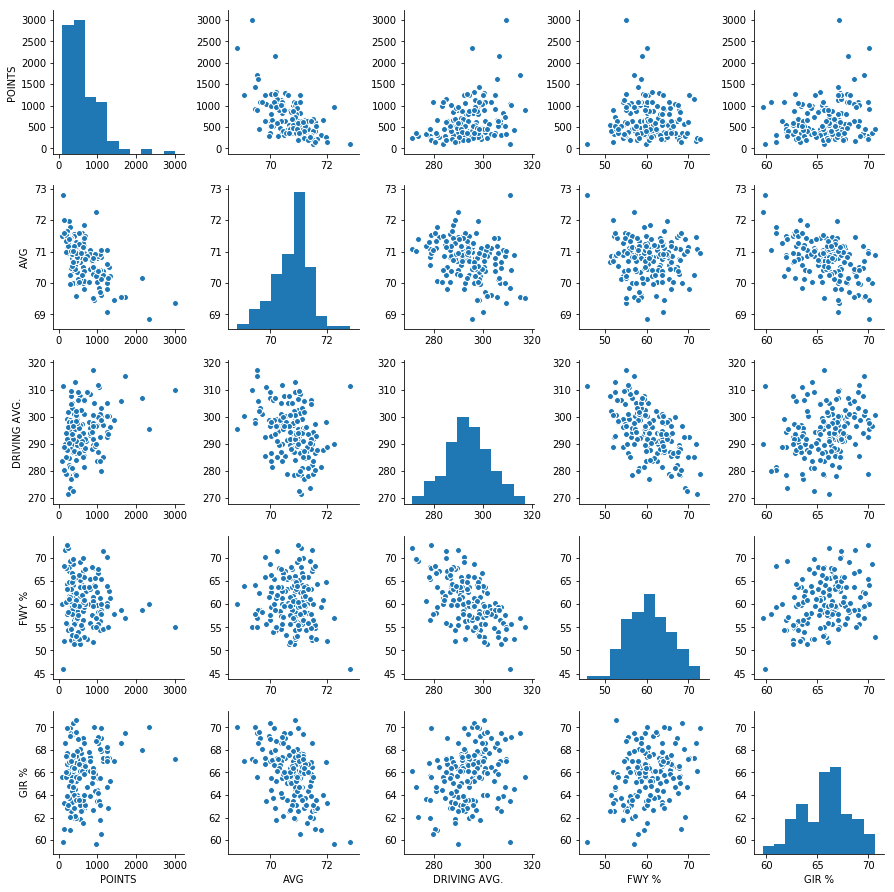

In [13]:
sns.pairplot(df_2017[['POINTS', 'AVG', 'DRIVING AVG.',
       'FWY %', 'GIR %']])

In [14]:
import sklearn
import scipy.stats as stats

In [17]:
from sklearn.linear_model import LinearRegression

In [23]:
stats = df_2017.drop(['POINTS', 'NAME'], axis = 1)

In [24]:
lm = LinearRegression()

In [27]:
lm.fit(stats[['AVG', 'DRIVING AVG.', 'FWY %', 'GIR %']], df_2017['POINTS'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)